# Imports

In [1]:
import json
import os
import pandas as pd
import re

In [2]:
import spacy
from spacy import displacy
from spacy.tokens import Span, Doc

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import pandas as pd
from datasets import Dataset
from datasets import load_dataset, load_from_disk
from datasets import load_dataset_builder

D:\Anaconda3\envs\nlp_torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
%run PII_Util.py

# Data

In [6]:
dataset_builder = load_dataset_builder('polyglot_ner')

D:\Anaconda3\envs\nlp_torch\Lib\site-packages\datasets\load.py:1454: FutureWarning: The repository for polyglot_ner contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/polyglot_ner
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [7]:
splits = dataset_builder.info.splits
print("Available splits:", splits.keys())

Available splits: dict_keys(['train'])


In [8]:
dataset_builder.info

DatasetInfo(description='Polyglot-NER\nA training dataset automatically generated from Wikipedia and Freebase the task\nof named entity recognition. The dataset contains the basic Wikipedia based\ntraining data for 40 languages we have (with coreference resolution) for the task of\nnamed entity recognition. The details of the procedure of generating them is outlined in\nSection 3 of the paper (https://arxiv.org/abs/1410.3791). Each config contains the data\ncorresponding to a different language. For example, "es" includes only spanish examples.\n', citation='@article{polyglotner,\n         author = {Al-Rfou, Rami and Kulkarni, Vivek and Perozzi, Bryan and Skiena, Steven},\n         title = {{Polyglot-NER}: Massive Multilingual Named Entity Recognition},\n         journal = {{Proceedings of the 2015 {SIAM} International Conference on Data Mining, Vancouver, British Columbia, Canada, April 30- May 2, 2015}},\n         month     = {April},\n         year      = {2015},\n         publisher

In [9]:
splits['train']

SplitInfo(name='train', num_bytes=6286855097, num_examples=21070925, shard_lengths=None, dataset_name=None)

In [14]:
%%time
dataset = load_dataset("polyglot_ner",languages=["en"], ignore_verifications=True)
# dataset = load_dataset("polyglot_ner",languages=["en"], download_mode='force_redownload')

D:\Anaconda3\envs\nlp_torch\Lib\site-packages\datasets\load.py:2516: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(
Generating train split:   2%|▋                                    | 423982/21070925 [01:33<1:16:15, 4512.42 examples/s]


CPU times: total: 1min 35s
Wall time: 1min 38s


In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'lang', 'words', 'ner'],
        num_rows: 423982
    })
})

In [17]:
sample_entries = dataset["train"][0:10]

In [18]:
df_dataset = pd.DataFrame(dataset["train"])

In [19]:
df_dataset.head()

,id,lang,words,ner
0,0,en,"[The, basilikon, (, ,, "", imperial, [, coin, ]...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,1,en,"[Migratory, along, the, south-eastern, coast, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, LOC, O..."
2,2,en,"[Irene, Luxbacher, ,, born, December, 10, ,, 1...","[PER, PER, O, O, O, O, O, O, O, LOC, O, LOC, O..."
3,3,en,"[The, fruit, is, a, berry, or, capsule, .]","[O, O, O, O, O, O, O, O]"
4,4,en,"[Facts, The, two, administrators, of, T&D, Ind...","[O, O, O, O, O, O, O, O, O, O, ORG, O, O, O, O..."


# EDA

In [25]:
col_tokens = 'words'
col_labels = 'ner'

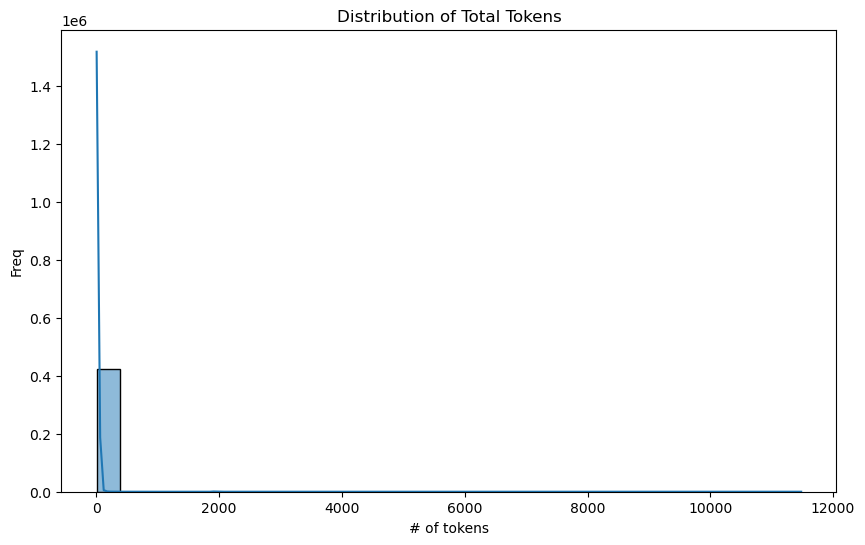

In [24]:
df_dataset['total_tokens'] = df_dataset[col_tokens].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df_dataset['total_tokens'], bins=30, kde=True)
plt.title('Distribution of Total Tokens')
plt.xlabel('# of tokens')
plt.ylabel('Freq')
plt.show()

In [27]:
%%time
df_dataset['token_index'] = df_dataset[col_tokens].apply(lambda x: list(range(len(x))))

# Explode the lists in each column, keep track of the original index and list index values
df_tokens = df_dataset.set_index('id')[[col_tokens,col_labels, 'token_index']].apply(lambda col: col.explode()).reset_index(drop=False)
df_tokens.columns = ['id', 'token', 'labels', 'token_index']
df_tokens

CPU times: total: 4.52 s
Wall time: 5.07 s


,id,token,labels,token_index
0,0,The,O,0
1,0,basilikon,O,1
2,0,(,O,2
3,0,",",O,3
4,0,"""",O,4
...,...,...,...,...
10000236,423981,type,O,12
10000237,423981,of,O,13
10000238,423981,skiing,O,14
10000239,423981,competition,O,15


In [28]:
ser_value_counts = df_tokens.labels.value_counts()

# # new_index = ser_value_counts.index.map(id2classes)

# # Create a new Series with mapped values
# pd.Series(ser_value_counts.values, index=new_index)
ser_value_counts

labels
O      9257976
ORG     260758
PER     246198
LOC     235309
Name: count, dtype: int64